Training conditional VAE on torque level with DMP

In [1]:
import os, time, tqdm, sys
import numpy as np
import torch

# add parent directory to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from models.dmp import CanonicalSystem, SingleDMP
from models.vae import DmpCVAE, DM
from torch.utils.data import DataLoader
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop
from matplotlib import pyplot as plt
print(os.getcwd())

/home/binzhao/Documents/code/VAE_DMP_mani/number_write_task


In [2]:
# create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

run_time = 1
dt = 0.01
shape = (2, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)

Load the data and normalize the data

In [3]:
train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
test_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
train_dataset.load_data('../data/number_write/train_torque.npz', device=device)
#test_dataset.load_data('../data/number_write/test_torque.npz', device=device)

train_dataset.torque = train_dataset.normalize_data(device=device)
#test_dataset.torque = test_dataset.normalize_data(device=device)

print("train dataset size: ", len(train_dataset))
#print("test dataset size: ", len(test_dataset))

train dataset size:  100000


In [4]:
# create dataloader for training and testing
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
#test_iter = DataLoader(test_dataset, batch_size=64, shuffle=True)
vae_net = DmpCVAE(dmp=dmp, shape=shape, nclass=10, nhid=8, ncond=8)
vae_net.to(device)

DmpCVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv1d(2, 16, kernel_size=(5,), stride=(2,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
      (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
      (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
        (mlp): Se

/home/binzhao/Documents/code/VAE_DMP_mani/utils/data_loader.py:220: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return torque.T, label.T


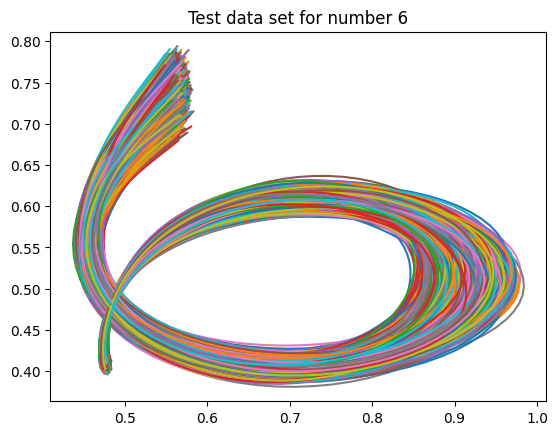

In [5]:
number = 6
for x, y in train_iter:
    # get index of y equal to number
    index = torch.where(y == number)[0]
    plt.plot(x[index, 0, :].cpu().T, x[index, 1, :].cpu().T)
plt.title("Test data set for number " + str(number))
plt.axis('equal')
plt.show()

In [6]:
# %% train model
lr = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vae_net.parameters()), lr=lr, weight_decay=0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

Define the early stop function, load the function

In [7]:
# %% if load
save_name = "cVAE_torque.pt"
retrain = True
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location=device)
        vae_net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for g in optimizer.param_groups:
            g['lr'] = lr

max_epochs = 100
early_stop = EarlyStop(patience=10, save_name=save_name)

Model parameters have already been trained before. Retrain ? (y/n)


/tmp/ipykernel_24009/254655288.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_name, map_location=device)


Training the network

training on  cuda


100%|████████| 1563/1563 [00:03<00:00, 406.49it/s]

epoch 0, train loss 0.0000 , time 3.8 sec


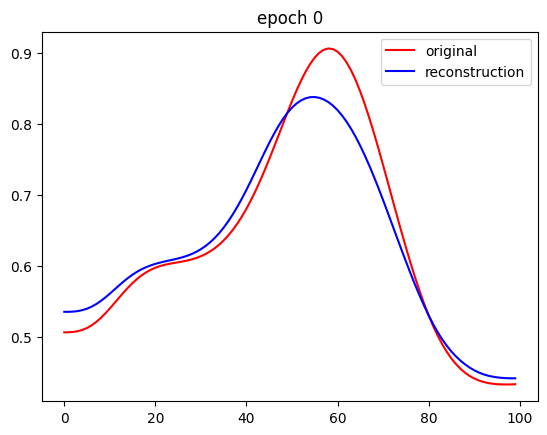

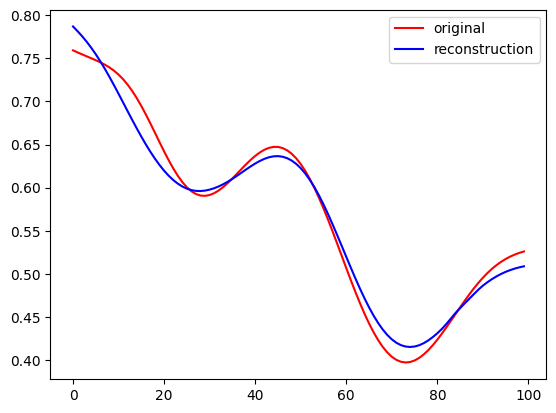

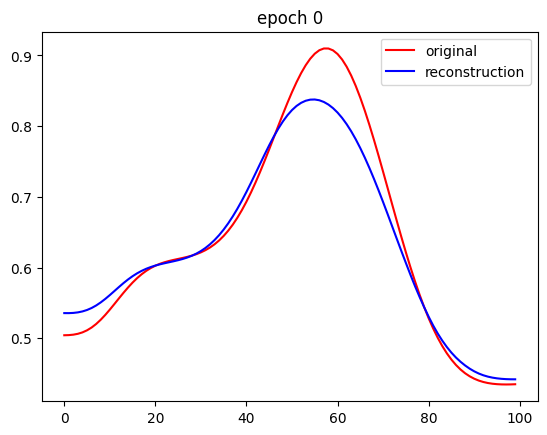

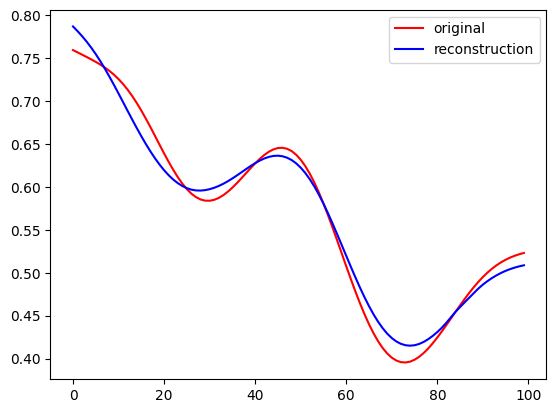

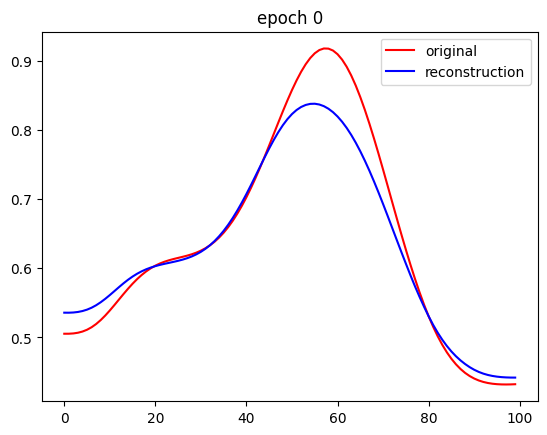

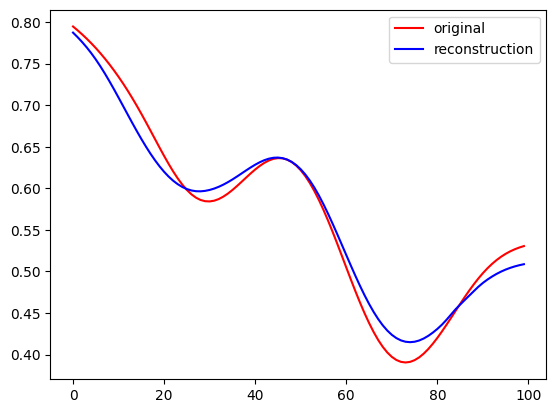

100%|████████| 1563/1563 [00:03<00:00, 450.10it/s]


epoch 1, train loss 0.0000 , time 3.5 sec


100%|████████| 1563/1563 [00:03<00:00, 448.57it/s]


epoch 2, train loss 0.0000 , time 3.5 sec


100%|████████| 1563/1563 [00:03<00:00, 446.93it/s]


epoch 3, train loss 0.0000 , time 3.5 sec


100%|████████| 1563/1563 [00:03<00:00, 444.55it/s]


epoch 4, train loss 0.0000 , time 3.5 sec
EarlyStopping counter: 1 out of 10


100%|████████| 1563/1563 [00:03<00:00, 448.90it/s]


epoch 5, train loss 0.0000 , time 3.5 sec
EarlyStopping counter: 2 out of 10


100%|████████| 1563/1563 [00:03<00:00, 453.20it/s]


epoch 6, train loss 0.0000 , time 3.4 sec


100%|████████| 1563/1563 [00:03<00:00, 440.58it/s]


epoch 7, train loss 0.0000 , time 3.5 sec


100%|████████| 1563/1563 [00:03<00:00, 455.11it/s]


epoch 8, train loss 0.0000 , time 3.4 sec
EarlyStopping counter: 1 out of 10


100%|████████| 1563/1563 [00:03<00:00, 453.82it/s]


epoch 9, train loss 0.0000 , time 3.4 sec
EarlyStopping counter: 2 out of 10


100%|████████| 1563/1563 [00:03<00:00, 453.49it/s]


epoch 10, train loss 0.0000 , time 3.4 sec


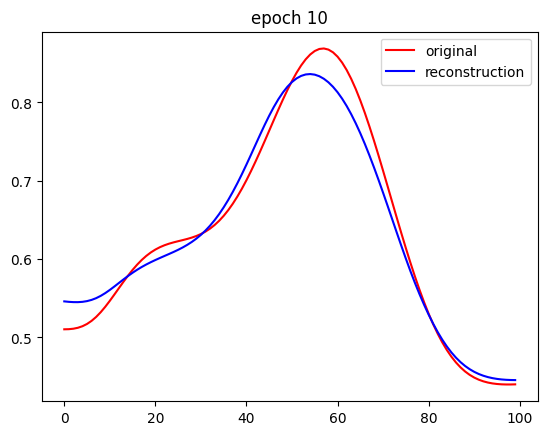

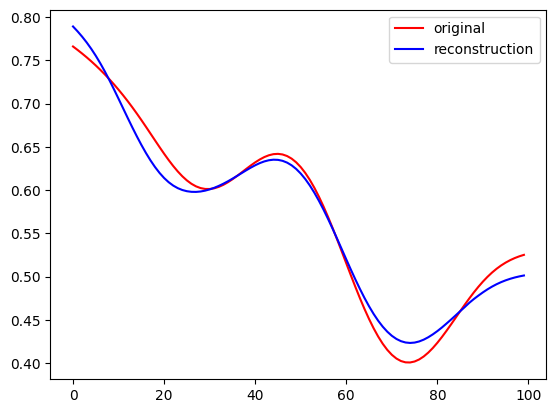

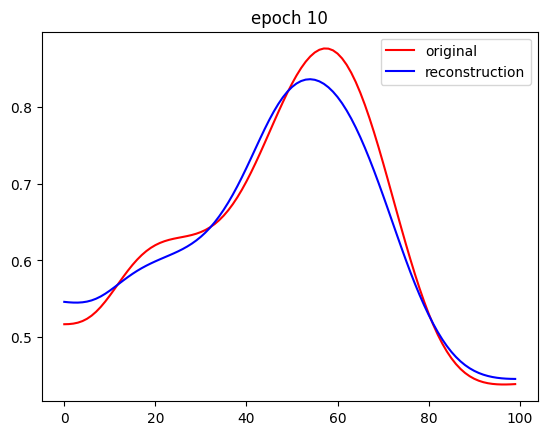

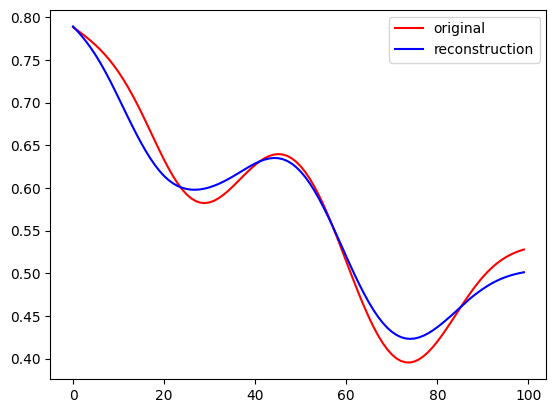

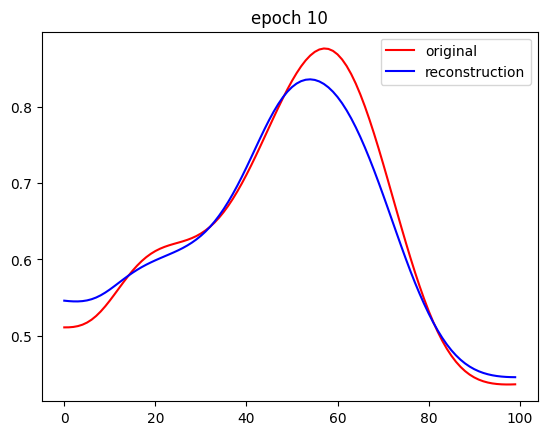

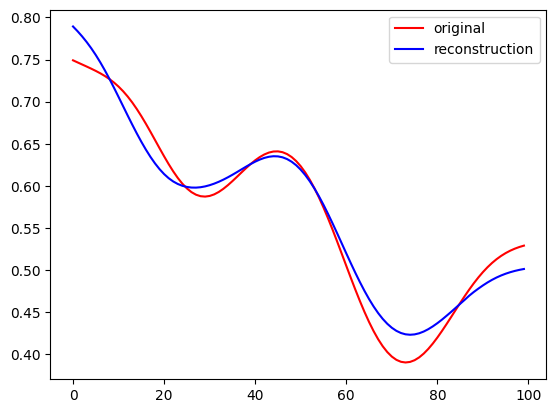

EarlyStopping counter: 3 out of 10


100%|████████| 1563/1563 [00:03<00:00, 453.67it/s]


epoch 11, train loss 0.0000 , time 3.4 sec
EarlyStopping counter: 4 out of 10


100%|████████| 1563/1563 [00:03<00:00, 443.34it/s]


epoch 12, train loss 0.0000 , time 3.5 sec
EarlyStopping counter: 5 out of 10


100%|████████| 1563/1563 [00:03<00:00, 437.19it/s]


epoch 13, train loss 0.0000 , time 3.6 sec
EarlyStopping counter: 6 out of 10


100%|████████| 1563/1563 [00:03<00:00, 445.93it/s]


epoch 14, train loss 0.0000 , time 3.5 sec
EarlyStopping counter: 7 out of 10


100%|████████| 1563/1563 [00:03<00:00, 431.23it/s]


epoch 15, train loss 0.0000 , time 3.6 sec
EarlyStopping counter: 8 out of 10


100%|████████| 1563/1563 [00:03<00:00, 435.37it/s]


epoch 16, train loss 0.0000 , time 3.6 sec
EarlyStopping counter: 9 out of 10


100%|████████| 1563/1563 [00:03<00:00, 442.46it/s]

epoch 17, train loss 0.0000 , time 3.5 sec
EarlyStopping counter: 10 out of 10


In [8]:
plt.ion()
print("training on ", device)
for epoch in range(max_epochs):
    vae_net.train()
    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm.tqdm(train_iter, ncols=50):
        X = X.to(device)
        # only use the first dimension of y
        y = y[:, 0].to(device)
        X_hat, mean, logvar = vae_net(X, y)

        l = vae_net.loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

    # ------------ plot the training result ------------
    check_number = 5
    if epoch % 10 == 0:
        for i in range(X.shape[0]):
            if y[i] == check_number:
                data = X[i, :, :].cpu().numpy()
                data1 = X_hat[i, :, :].detach().cpu().numpy()
                # plot the data with red line
                # add title
                plt.title("epoch " + str(epoch))
                plt.plot(data[0, :], "r")
                plt.plot(data1[0, :], "b")
                # plot legend
                plt.legend(["original", "reconstruction"])
                plt.show()

                plt.plot(data[1, :], "r")
                plt.plot(data1[1, :], "b")
                plt.legend(["original", "reconstruction"])
                plt.show()

    if (early_stop(train_loss, vae_net, optimizer)):
        break

Generate trajectory from the torque

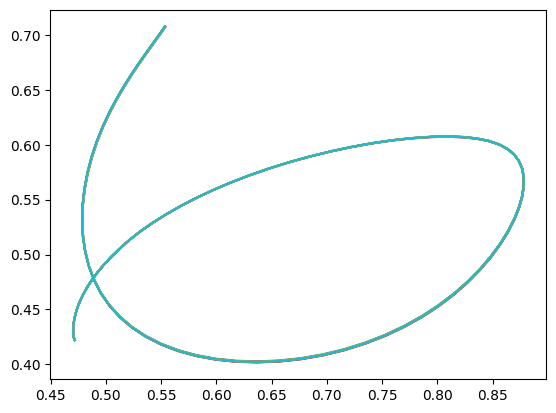

In [9]:
vae_net.eval()
number = 6
for i in range(10):
    with torch.no_grad():
        torque = vae_net.generate(number)    
    # plot the generated force
    plt.plot(torque[:, 0, :].cpu().T, torque[:, 1, :].cpu().T)

denormalize the data

torch.Size([1, 2, 100])


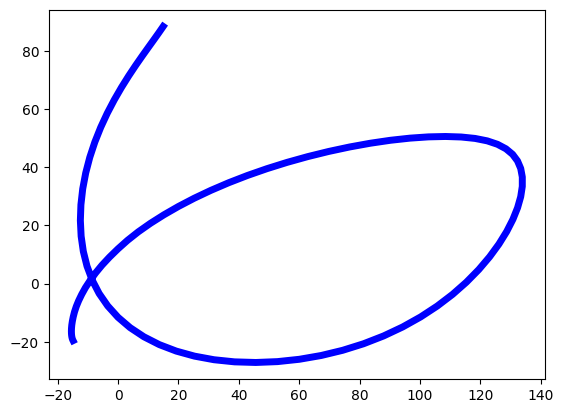

In [10]:
real_torque = train_dataset.denormalize_data(torque)
print(real_torque.shape)
plt.plot(real_torque[:, 0, :].cpu().T, real_torque[:, 1, :].cpu().T, "b", linewidth=5)

Generate trajectory by DM system

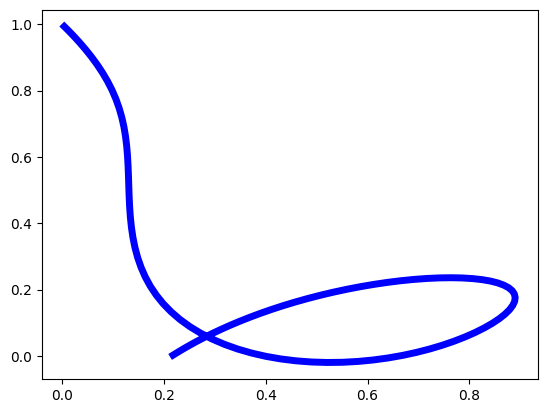

In [11]:
ax = 25
bx = ax/4
dt = 0.01
x0 = np.array([0, 1]).T

dm = DM(ax=ax, bx=bx, ndof=2, dt=dt)

goal = np.array([0.2, 0]).T

# forward to get the trajectory
traj = dm(real_torque, goal=goal, x0=x0)
traj.shape
plt.plot(traj[:, 0, :].cpu().T, traj[:, 1, :].cpu().T, "b", linewidth=5)

In [12]:
y0 = np.array([[0, 1]])
print(y0.shape)
goal = np.array([[0.2, 0]])


(1, 2)


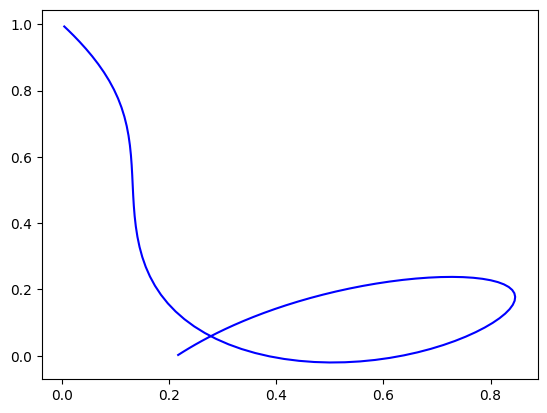

In [13]:
dmp_traj = vae_net.get_trajectory(real_torque, y0, goal)
plt.plot(dmp_traj[:, 0, :].T, dmp_traj[:, 1, :].T, "b")